<a href="https://colab.research.google.com/github/ElhorriAbdelBasset/PyTorch-Fundemantals/blob/main/PyTorch_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.13.0+cu116
torchvision version: 0.14.0+cu116


In [22]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [103]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [11]:
train_data[0][0].shape, test_data[0][0].shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

In [13]:
len(train_data.data), len(train_data.targets)

(10000, 10000)

In [14]:
len(test_data.data), len(test_data.targets)

(10000, 10000)

In [19]:
classes = train_data.classes

In [17]:
BATCH = 32

train_dataloader = DataLoader(
    train_data,
    batch_size = BATCH,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = BATCH,
    shuffle=False
)

In [31]:
class FashionMNISTModel(nn.Module):
  def __init__(self, ins, outs, hidden) -> None:
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=ins, out_features=hidden),
        nn.ReLU(),
        nn.Linear(in_features=hidden, out_features=hidden),
        nn.ReLU(),
        nn.Linear(in_features=hidden, out_features=outs)
    )

  def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [39]:
model = FashionMNISTModel(784,len(classes), 10).to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [60]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
def accuracy_fn(Y_gt=None, Y_pr=None):
  corr = torch.eq(Y_gt, Y_pr).sum().item()
  return (corr / len(Y_gt)) * 100

In [34]:
from timeit import default_timer as timer

In [41]:
def training(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             optimizer: torch.optim.Optimizer,
             device: torch.device = device):
  train_loss, train_acc = 0, 0
  for batch, (X, Y) in enumerate(dataloader):
    X,Y = X.to(device), Y.to(device)
    predictions = model(X)
    loss = loss_fn(predictions, Y)
    acc = accuracy_fn(Y, predictions.argmax(dim=1))
    train_loss += loss
    train_acc += acc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f"Train Loss {train_loss} | Train Accuracy {train_acc}")

def testing(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             optimizer: torch.optim.Optimizer,
             device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  for batch, (X, Y) in enumerate(dataloader):
    X,Y = X.to(device), Y.to(device)
    predictions = model(X)
    loss = loss_fn(predictions, Y)
    acc = accuracy_fn(Y, predictions.argmax(dim=1))
    test_loss += loss
    test_acc += acc

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  print(f"Test Loss {test_loss} | Test Accuracy {test_acc}")


In [78]:
def eval_model(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             optimizer: torch.optim.Optimizer,
             device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()
  for X, Y in dataloader:
    X,Y = X.to(device), Y.to(device)
    predictions = model(X)
    loss = loss_fn(predictions, Y)
    acc = accuracy_fn(Y, predictions.argmax(dim=1))
    test_loss += loss
    test_acc += acc

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return {"Model": model.__class__.__name__,
          "Test Loss": test_loss.item(),
          "Test Accuracy": test_acc}, predictions.argmax(dim=1)

In [46]:
train_start = timer()

epochs = 4

for epoch in range(epochs):
  print(f"Epoch {epoch}   ---------------\n")
  training(model, train_dataloader, loss_fn, optimizer)
  testing(model, test_dataloader, loss_fn, optimizer)

train_end = timer()
print(train_end-train_start)

Epoch 0   ---------------

Train Loss 0.5708737969398499 | Train Accuracy 79.15335463258786
Test Loss 0.48787787556648254 | Test Accuracy 82.59784345047923
Epoch 1   ---------------

Train Loss 0.5371489524841309 | Train Accuracy 80.64097444089457
Test Loss 0.5035771727561951 | Test Accuracy 81.95886581469648
Epoch 2   ---------------

Train Loss 0.5164942741394043 | Train Accuracy 81.35982428115015
Test Loss 0.6154431104660034 | Test Accuracy 77.47603833865814
Epoch 3   ---------------

Train Loss 0.49815085530281067 | Train Accuracy 81.9888178913738
Test Loss 0.5218081474304199 | Test Accuracy 80.79073482428115
8.924942212000133


In [48]:
classModel = eval_model(model, train_dataloader, loss_fn, optimizer)

In [127]:
class ConvModel(nn.Module):
  def __init__(self, ins, hidden, outs) -> None:
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=ins,
                  out_channels=hidden,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,
                  out_channels=hidden,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                        stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden,
                  out_channels=hidden,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,
                  out_channels=hidden,
                  kernel_size=3,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                        stride=2)
    )
    self.classification = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden*7*7, out_features=outs)
    )

  def forward(self, X):
    return self.classification(self.block_2(self.block_1(X)))

In [128]:
model = ConvModel(ins=1, hidden=10, outs=len(classes)).to(device)
model

ConvModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [129]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [130]:
train_start = timer()

epochs = 11

for epoch in range(epochs):
  print(f"Epoch {epoch}   ---------------\n")
  training(model, train_dataloader, loss_fn, optimizer)
  if epoch % 10 == 0 : testing(model, test_dataloader, loss_fn, optimizer)

train_end = timer()
print(train_end-train_start)

Epoch 0   ---------------

Train Loss 1.8138347864151 | Train Accuracy 32.617811501597444
Test Loss 0.9195432662963867 | Test Accuracy 67.53194888178913
Epoch 1   ---------------

Train Loss 0.6406013369560242 | Train Accuracy 76.95686900958466
Epoch 2   ---------------

Train Loss 0.5006733536720276 | Train Accuracy 81.92891373801918
Epoch 3   ---------------

Train Loss 0.4437004625797272 | Train Accuracy 83.95567092651757
Epoch 4   ---------------

Train Loss 0.40872976183891296 | Train Accuracy 85.24361022364218
Epoch 5   ---------------

Train Loss 0.3867621123790741 | Train Accuracy 85.90255591054313
Epoch 6   ---------------

Train Loss 0.36587145924568176 | Train Accuracy 87.05071884984025
Epoch 7   ---------------

Train Loss 0.3477116525173187 | Train Accuracy 87.56988817891374
Epoch 8   ---------------

Train Loss 0.3382503390312195 | Train Accuracy 88.11900958466454
Epoch 9   ---------------

Train Loss 0.32772740721702576 | Train Accuracy 88.31869009584665
Epoch 10   -----

In [131]:
convModel, preds = eval_model(model, test_dataloader, loss_fn, optimizer)

In [132]:
import pandas as pd

In [133]:
results = pd.DataFrame([convModel, classModel])
results

,Model,Test Loss,Test Accuracy
0,ConvModel,0.309825,88.548323
1,FashionMNISTModel,0.522063,80.770767


In [76]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    %pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.2 MB/s eta 0:00:00
mlxtend version: 0.21.0


In [134]:
def inference(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             device: torch.device = device):
  predections = []
  model.eval()
  with torch.inference_mode():
    for X, Y in dataloader:
      X,Y = X.to(device), Y.to(device)
      preds = torch.softmax(model(X), dim=1).argmax(dim=1)

      predections.append(preds.cpu())

  return torch.cat(predections)

In [135]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [136]:
predections = inference(model, test_dataloader)

In [138]:
confmat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
confmat_tensor = confmat(preds=predections, target=test_data.targets)

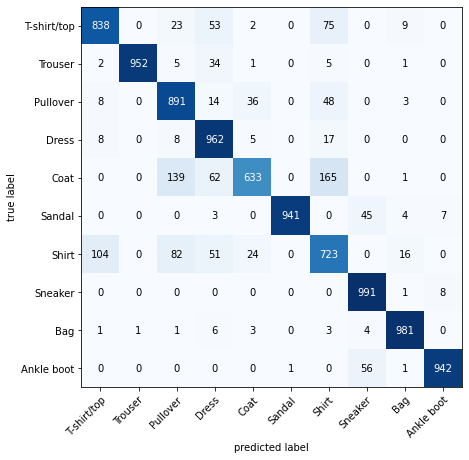

In [139]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=train_data.classes, 
    figsize=(10, 7)
);

### To Save The Model

```
torch.save(obj=model.state_dict(), f=MODEL_PATH)
```
### To Load The Model

```
model = Instance_of_the_same_model()
model.load_state_dict(torch.load(f=MODEL_PATH))
```

